<h1><center>IMT2118 - Ciencia de Datos Geoespaciales </center></h1>
<h2><center>E2:  Islas de calor urbanas y violencia contra la mujer en Nueva York  </center></h2>

Cuando hablamos de violencia de género, nos referimos a conductas violentas cuya motivación última es la pertenencia a un género. Según la subcomisión de estadísticas de género (SEG), durante el año 2020 hubo 44 femicidos consumados y 163 intentos frustrados $^1$. Es por esto que la violencia de género es un problema relevante, el cual requiere de la formulación de políticas públicas para ser abordado correctamente. 

Para los objetivos de este trabajo, se abordará exclusivamente la violencia ejercida desde hombres a mujeres, y limitada al siguiente subconjunto de crímenes obtenidos de las columnas de nuestro dataset:violación, acoso, secuestro, crímenes sexuales y homicidio.



**Referencias:**
1. Subcomisión de Estadísticas de Género (SEG) (n.d.). VIolencia de género. EstadíSticas de géNero. Retrieved July 2, 2023, from https://www.estadisticasdegenero.cl/indicadores/violencia-de-genero/

### 1. Importaciones y lecturas

In [80]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box
import numpy as np
import seaborn as sns
import libpysal as ps
from libpysal import weights
import esda

In [2]:
# ee.Authenticate()
ee.Initialize()

In [3]:
big_crimes = gpd.read_file('NYPD_violence_against_women.gpkg')
big_crimes.to_crs('EPSG:4326', inplace=True)

In [4]:
manz = gpd.read_file('squares/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


<Axes: >

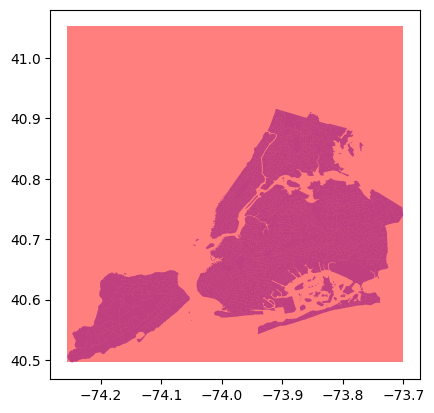

In [5]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [6]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]
aoi2 = ee.Geometry.Point([x-.1, y-.1])

### 2. Visualización de HeatMaps

In [7]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())


def applyScaleFactors(image):
    thermalband = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

In [8]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate('2022-05-30', '2022-07-10').map(cloudMask)
filtered_l8 = collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
landsatST = filtered_l8.map(applyScaleFactors)
mean_landsatST = landsatST.mean()
clip_mean_ST = mean_landsatST.clip(aoi)

images=collection.aggregate_array('system:id').getInfo()
print(len(images))

7


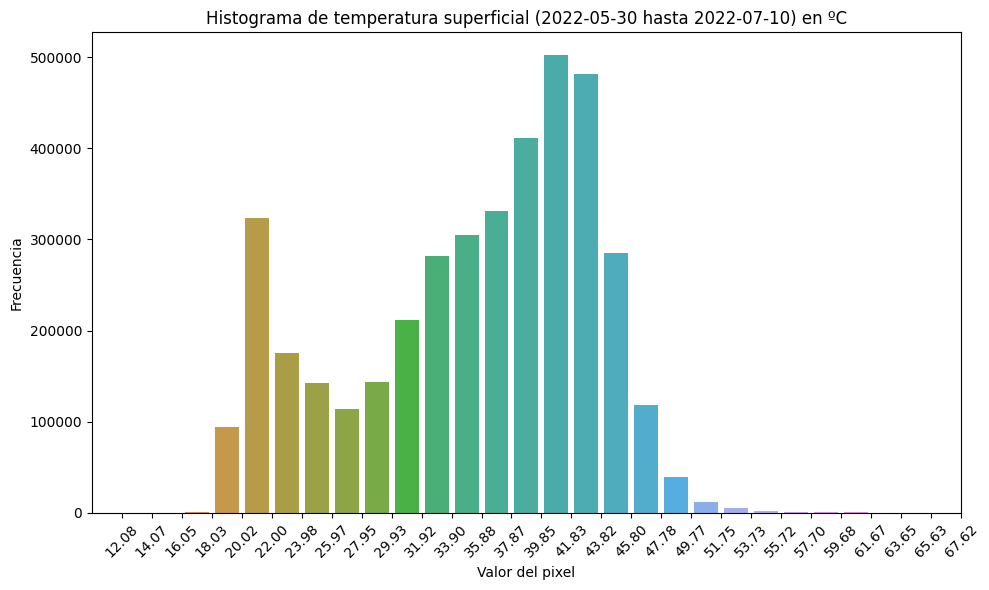

In [9]:
values_ST = clip_mean_ST.select('ST_B10')
histogram_ST = values_ST.reduceRegion(
    reducer=ee.Reducer.histogram(30),
    geometry=aoi,
    scale=30
)

values_ST = clip_mean_ST.select('ST_B10')
histogram_info = histogram_ST.get('ST_B10').getInfo()
histogram_values = histogram_info['histogram']
bucket_means = histogram_info['bucketMeans']

num_bins = len(histogram_values)
min_value = bucket_means[0] - (bucket_means[1] - bucket_means[0]) / 2
max_value = bucket_means[-1] + (bucket_means[-1] - bucket_means[-2]) / 2
bin_edges = np.linspace(min_value, max_value, num_bins + 1)

histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=histogram_df, x='bin_edges', y='histogram_values')
plt.xlabel('Valor del pixel')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura superficial (2022-05-30 hasta 2022-07-10) en ºC')

tick_positions = np.arange(len(bin_edges[:-1])) + 0.5
tick_labels = [f'{val:.2f}' for val in bin_edges[:-1]]
plt.xticks(tick_positions, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()

In [10]:
Map = geemap.Map()
heat_params = {'min': 20,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'purple', 'yellow', 'orange','red']}
Map.addLayer(clip_mean_ST, heat_params, 'ST')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

In [11]:
heat_islands = clip_mean_ST.gt(48).selfMask()
hi_params = {
    'bands': 'ST_B10',
    'palette': 'black'}
Map.addLayer(heat_islands, hi_params, 'Heat Islands')

A continuación, veremos añadiremos al plot distintos rangos de fechas.

In [12]:
layer_list = []
for i in range(1, 11):
    col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate(f'2022-{i}-30', f'2022-{i+2}-10').map(cloudMask)
    filtered= collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
    landST = filtered_l8.map(applyScaleFactors)
    mean_ST = landsatST.mean()
    clip_mean_ST = mean_landsatST.clip(aoi)
    layer_list.append(clip_mean_ST)

In [13]:
layer_list

In [14]:
Map2 = geemap.Map()
for i,layer in enumerate(layer_list):
    layer
    Map2.addLayer(layer, heat_params, f'H.I 0{i+1}-30 to {i+3}-10')

Map2.centerObject(aoi2, 10)
Map2

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

### 3. Visualizar información de crimenes

<Axes: >

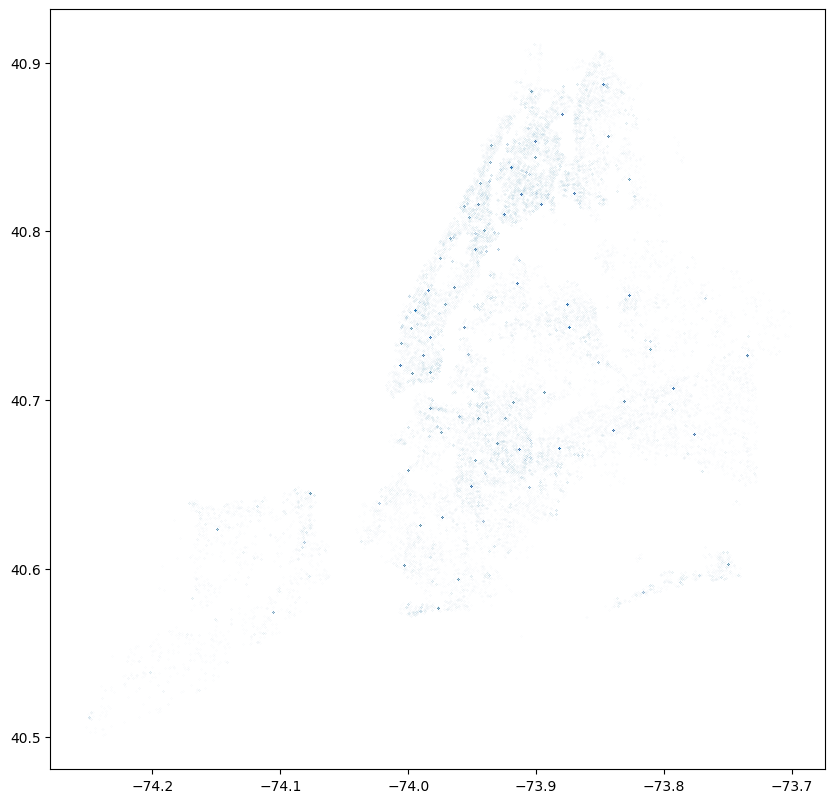

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
big_crimes.plot(ax=ax, alpha=0.1, markersize=0.01)

### 4. Normalizar información de crímenes por cantidad de mujeres para el periodo relevante (2022)

In [16]:
every_manz_crimes = list()
for i in range(len(manz)):
    n_crimes = big_crimes.within(manz.iloc[i].geometry)
    every_manz_crimes.append(sum(n_crimes))
manz["n_crimes"] = every_manz_crimes

Ahora leemos el censo 2020 de NY, y nos quedamos con las manzanas en las cuales tenemos 

In [17]:
census_tracts = gpd.read_file('census/nyc_census_tracts.csv')

In [18]:
manz_filtered = manz[manz['GEOID'].isin(census_tracts['CensusTract'].unique())]
census_filtered = census_tracts[census_tracts['CensusTract'].isin(manz['GEOID'].unique())]

In [49]:
census_filtered = census_filtered[['CensusTract', 'TotalPop', 'Women']]

In [50]:
squares = manz_filtered.merge(census_filtered, left_on='GEOID', right_on='CensusTract')
squares = squares.drop('CensusTract', axis=1)

In [51]:
def proportion(TotalPop, subgroup):
    if float(TotalPop) == 0:
        return 0
    else:
        return float(subgroup)/float(TotalPop)

In [52]:
cant_mujeres = sum(squares['Women'].astype('float64'))
squares['women_prop'] = squares.apply(lambda x: proportion(x.TotalPop, x.Women), axis=1)
squares['area_km2'] = squares.to_crs('EPSG:2263').geometry.area * 0.000000092903
squares['crimes_prop'] = squares.apply(lambda x: proportion(x.area_km2, x.n_crimes), axis=1)
squares.sample(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,PUMA,Shape_Leng,Shape_Area,geometry,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_prop
1495,422,3,Brooklyn,042200,3042200,None,Gravesend (East)-Homecrest,BK1501,BK15,BK15 Sheepshead Bay-Gravesend (East) (CD 15 Ap...,...,4315,6172.108908,2.443186e+06,"POLYGON ((-73.96727 40.60726, -73.96696 40.605...",2,3474,1645,0.473518,0.226979,8.811377
1731,854,3,Brooklyn,085400,3085400,None,East Flatbush-Farragut,BK1702,BK17,BK17 East Flatbush (CD 17 Approximation),...,4317,7324.948061,1.385790e+06,"POLYGON ((-73.93738 40.64490, -73.93728 40.643...",12,1941,1035,0.533230,0.128744,93.208184
187,132,2,Bronx,013200,2013200,None,Throgs Neck-Schuylerville,BX1002,BX10,BX10 Co-op City-Throgs Neck (CD 10 Approximation),...,4210,18509.576002,6.520114e+06,"MULTIPOLYGON (((-73.81443 40.81352, -73.81446 ...",20,7426,3720,0.500943,0.605739,33.017546


<Axes: >

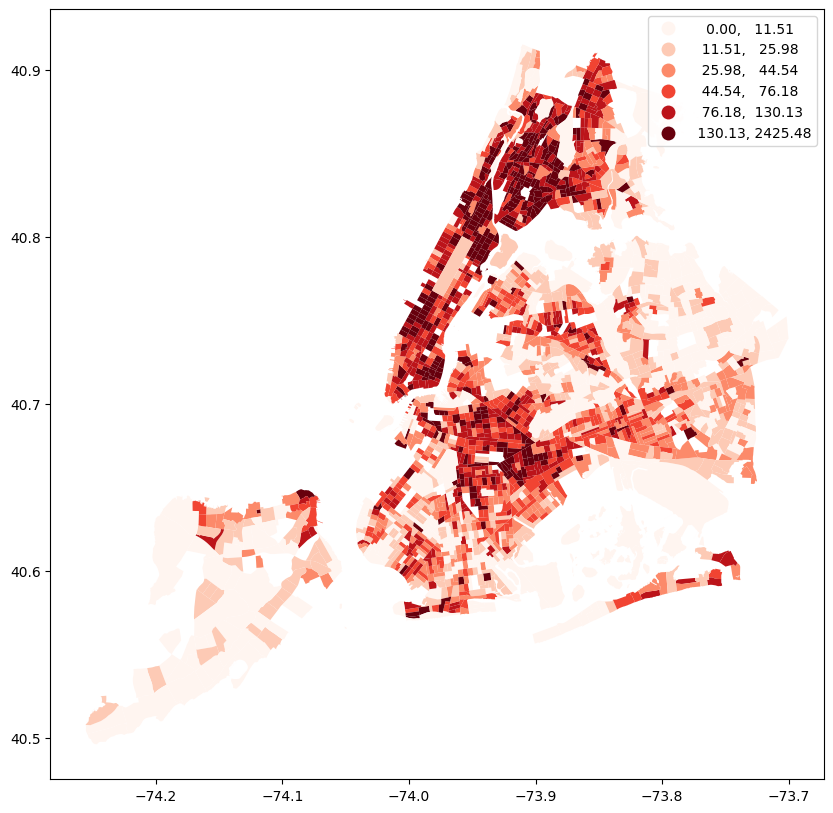

In [23]:
squares.plot(column='crimes_prop', scheme='quantiles', k=6, cmap='Reds', figsize=(10,10), legend=True)

### 5. Discretización de raster de temperatura

In [53]:
list_temp = list()
for sq in squares.iterrows():
    mean_temp = 0
    img_sq = clip_mean_ST.select('ST_B10').clip(sq[1][14])
    n_pix = len(np.array(img_sq).flatten())
    for pix in np.array(img_sq).flatten():
        print(pix)
        # mean_temp += pix
    list_temp.append(mean_temp/n_pix)

squares["mean_temperature"] = list_temp

EEException: Can't encode object: MULTIPOLYGON (((-74.04387761639944 40.69018767587401, -74.04350596078567 40.6896873596363, -74.04273533892976 40.69005019091781, -74.04278433380006 40.690120976691354, -74.04270428426766 40.6901552046445, -74.04255372037339 40.68996275979237, -74.0426392937119 40.68992817641353, -74.04269380819214 40.689997259609974, -74.04346752310298 40.68963699060623, -74.04351637245855 40.689191033742546, -74.04364078627445 40.68876656007293, -74.04397458556184 40.68858240705612, -74.04438521777247 40.68851617790029, -74.04478399106388 40.688595660115816, -74.04627539003668 40.689327425896934, -74.04680284898575 40.689953256266215, -74.0474765152837 40.689611369998204, -74.047729627631 40.689915318968794, -74.04758571924822 40.68998250732891, -74.0474312612351 40.68980389047109, -74.04689205500591 40.69005909832281, -74.04720029366251 40.69042481562394, -74.04711050698607 40.690470412850274, -74.04711582042361 40.69065580611837, -74.04718321412064 40.690747355049275, -74.04719492513735 40.69076326384838, -74.04721324567835 40.69079048732637, -74.04722568425278 40.69081957243567, -74.04723192827254 40.69084978826996, -74.04723182081725 40.690880375506964, -74.04722536457862 40.69091056549009, -74.04721272179357 40.690939599544606, -74.04719421016807 40.690966748043444, -74.0471702948939 40.690991328742676, -74.04714091053252 40.691010516344676, -74.04710814053631 40.69102620847252, -74.04707269656511 40.69103806434227, -74.0470353483505 40.69104582648133, -74.04699690697936 40.69104932632006, -74.04617167065449 40.69109798148653, -74.04614707208665 40.691122646033364, -74.04609551065151 40.69112006354922, -74.0460444245555 40.69111415266101, -74.04599418395566 40.6911049561975, -74.04592592767887 40.691082603798115, -74.04586027427413 40.691056116583574, -74.04460616482923 40.69057348495099, -74.04387761639944 40.69018767587401)), ((-74.03995040788483 40.70089063014033, -74.03945262913307 40.700533159823905, -74.03938278118848 40.70057769456149, -74.03771124796636 40.69934404034792, -74.03809786214774 40.6990395052444, -74.03822954445391 40.6983685916979, -74.03900043878028 40.69836989039119, -74.0393403767015 40.69811551483617, -74.03993272132986 40.69854442279385, -74.04025555083275 40.69880482330749, -74.04124261832222 40.69953674143506, -74.04174768868015 40.69914786356684, -74.03991248872623 40.697702040398596, -74.04166051914841 40.696452971639935, -74.04367371230778 40.69802040433027, -74.04363686211197 40.69804823269846, -74.04365651062231 40.69806409108808, -74.04270395810723 40.69880060058688, -74.04296505227515 40.69899936182236, -74.0410986123707 40.70049294338983, -74.04080080646241 40.7002685499267, -74.04031250973529 40.70062574919241, -74.04028808803947 40.70064361346732, -74.03995040788483 40.70089063014033)))

In [39]:
clip_mean_ST.select('ST_B10').getInfo()['properties']['system:footprint']['coordinates'][0][:-1]

[[-74.25559136315213, 40.49613398761199],
 [-73.70000906321272, 40.49613398761199],
 [-73.70000906321272, 41.05171628755141],
 [-74.25559136315213, 41.05171628755141]]

In [58]:
from time import time

#### No correr siguiente código, se importará el dataframe que se generó

In [62]:
init = time()
# Convert the geometries to GeoJSON format
squares['geometry_geojson'] = squares['geometry'].apply(lambda x: x.__geo_interface__)

# Create an empty list to store the mean temperatures
mean_temperatures = []

# Iterate over each row of the geodataframe
for index, row in squares.iterrows():
    # Get the geometry of the row
    geometry = row['geometry_geojson']
    clipped_image = clip_mean_ST.clip(geometry)
    
    # Compute the mean temperature within the geometry
    mean_temperature = clipped_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee.Geometry(geometry),
        scale=30
    ).get('ST_B10')
    
    # Append the mean temperature to the list
    mean_temperatures.append(mean_temperature.getInfo())
    if index%20==0:
        timer = time()
        delta = timer - init
        init = timer
        print(f'iteración {index}: {round(100*index/2034, 3)}% | Exec time: {delta}')

# Assign the mean temperatures to the 'mean_temperature' column in the geodataframe
squares['mean_temperature'] = mean_temperatures

iteración 0: 0.0% | Exec time: 1.266524076461792
iteración 20: 0.983% | Exec time: 19.927172899246216
iteración 40: 1.967% | Exec time: 23.9640691280365
iteración 60: 2.95% | Exec time: 20.358182907104492
iteración 80: 3.933% | Exec time: 19.50734806060791
iteración 100: 4.916% | Exec time: 23.8736629486084
iteración 120: 5.9% | Exec time: 19.17226791381836
iteración 140: 6.883% | Exec time: 19.727023124694824
iteración 160: 7.866% | Exec time: 20.476858854293823
iteración 180: 8.85% | Exec time: 20.509507179260254
iteración 200: 9.833% | Exec time: 19.811081886291504
iteración 220: 10.816% | Exec time: 19.354161024093628
iteración 240: 11.799% | Exec time: 19.566787004470825
iteración 260: 12.783% | Exec time: 23.7347571849823
iteración 280: 13.766% | Exec time: 20.817092895507812
iteración 300: 14.749% | Exec time: 23.64572787284851
iteración 320: 15.733% | Exec time: 19.699655055999756
iteración 340: 16.716% | Exec time: 20.088032960891724
iteración 360: 17.699% | Exec time: 20.0121

Este código demora 35 min en correr, por lo que guardamos el dataframe y lo cargamos.

In [64]:
# squares.to_file('squares_temperature.shp', driver="ESRI Shapefile")

### 6. Análisis de autocorrelación espacial

In [75]:
squares = gpd.read_file('cuadras_temperatura/squares_temperature.shp')
squares.sample(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,Shape_Area,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_pro,geometry_g,mean_tempe,geometry
1118,96.01,5,Staten Island,009601,5009601,None,Grasmere-Arrochar-South Beach-Dongan Hills,SI0201,SI02,SI02 Mid-Island (CD 2 Approximation),...,8.357606e+06,12,3744,2074,0.553953,0.776457,15.454813,"{""type"": ""Polygon"", ""coordinates"": [[[-74.0821...",42.962298,"POLYGON ((-74.08219 40.60194, -74.08184 40.601..."


<Axes: title={'center': 'Mapa de temperatura promedio (ºC) en julio 2022, NYC'}>

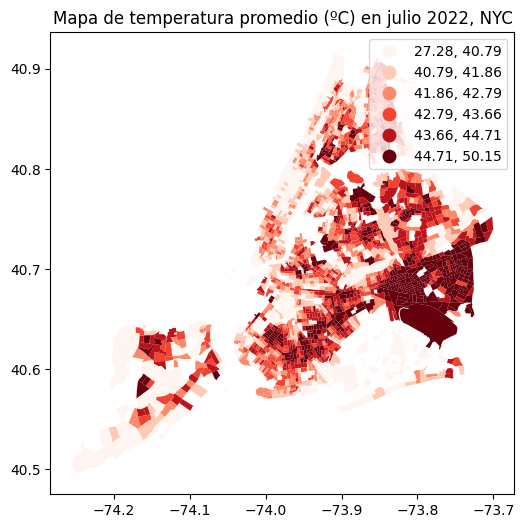

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Mapa de temperatura promedio (ºC) en julio 2022, NYC')
squares.plot(ax=ax, column='mean_tempe', scheme='quantiles', k=6, cmap='Reds', legend=True)

In [82]:
mean = squares.mean_tempe.mean()
sd = squares.mean_tempe.std()
squares['temp_std'] = (squares['mean_tempe'] - mean)/sd
squares['index'] = squares.index

In [81]:
squares.sample(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_pro,geometry_g,mean_tempe,geometry,temp_std
46,92,1,Manhattan,009200,1009200,None,East Midtown-Turtle Bay,MN0604,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,...,14,1717,895,0.521258,0.196809,71.135111,"{""type"": ""Polygon"", ""coordinates"": [[[-73.9712...",40.877065,"POLYGON ((-73.97122 40.75519, -73.97168 40.754...",-0.767401


In [84]:
w = weights.Queen.from_dataframe(squares, ids='index')

In [86]:
squares["temp_lag"] = weights.spatial_lag.lag_spatial(w, squares['temp_std'])

<Axes: title={'center': 'Lag espacial temperatura promedio (ºC) en julio 2022, NYC'}>

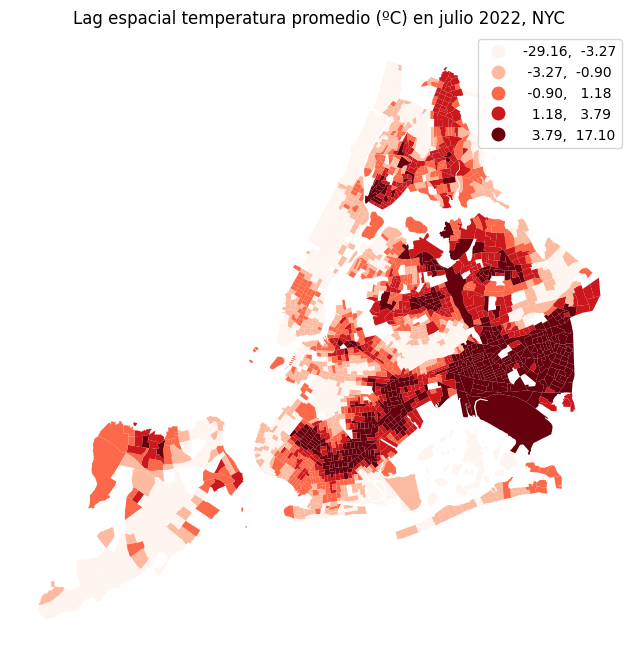

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
ax.set_title('Lag espacial temperatura promedio (ºC) en julio 2022, NYC')
squares.plot(ax=ax, column='temp_lag', scheme='quantiles', k=5, cmap='Reds', legend=True)